<a href="https://colab.research.google.com/github/rosehelfrich/Ky_School_data/blob/main/Predict_Classification%2C_and_Highly_Impacted_Schools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Column / Row options
pd.options.display.max_columns = None
pd.options.display.max_rows = 20

# Two decimal places and the thousands separator
pd.options.display.float_format = '{:,.2f}'.format

# KY df - load and clean

In [4]:
# Load dfs
df_scores = pd.read_csv('/content/drive/MyDrive/Colab Data/KY EPSB/All Years/df_scores.csv')
ky_spending_df = pd.read_csv('/content/drive/MyDrive/Colab Data/KY EPSB/All Years/published_ky_df_all.csv')
ky_spending_df = ky_spending_df.loc[:,['End Year', 'School Code', 'Level', 'Reported Spending per student', 'Money Difference per school',
       'Money Difference per student', 'Estimated Spending per student']]

# Duplicate classification columns
df_scores['Rating'] = df_scores['Classification']

# Reorder columns
reordered_columns = ['End Year', 'District Code', 'District', 'School Code', 'School', 'Level', 'Proficiency Rate', 'Classification', 'Rating']
df_scores = df_scores[reordered_columns]



In [5]:
# Merge into one df
df = pd.merge(df_scores, ky_spending_df, on=['End Year', 'School Code', 'Level'], how='left')

# Sort df & Reset index
df.sort_values(by=['End Year','District','School'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
# Take out "/Progressing"
df.replace(['Distinguished/Progressing', 'Proficient/Progressing', 'Needs Improvement/Progressing'], 
           ['Distinguished', 'Proficient', 'Needs Improvement'], inplace=True)

df['Rating'].replace(['Distinguished', 'Proficient', 'Needs Improvement'], np.NaN,inplace=True)

df = df.round({'Proficiency Rate': 0, 'Reported Spending per student': -1, 'Money Difference per school': -2, 
                               'Money Difference per student':-1, 'Estimated Spending per student': 1})

In [7]:
# This df now keeps the original data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10919 entries, 0 to 10918
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   End Year                        10919 non-null  float64
 1   District Code                   10919 non-null  int64  
 2   District                        10919 non-null  object 
 3   School Code                     10919 non-null  int64  
 4   School                          10919 non-null  object 
 5   Level                           10919 non-null  object 
 6   Proficiency Rate                10919 non-null  float64
 7   Classification                  8468 non-null   object 
 8   Rating                          2510 non-null   object 
 9   Reported Spending per student   7753 non-null   float64
 10  Money Difference per school     7753 non-null   float64
 11  Money Difference per student    7753 non-null   float64
 12  Estimated Spending per student  

In [8]:
df['Classification'].value_counts(dropna=False)

Needs Improvement    3059
NaN                  2451
Proficient           1505
Distinguished        1394
Medium                814
Low                   751
High                  527
Very High             212
Very Low              206
Name: Classification, dtype: int64

In [9]:
df['Level'].value_counts(dropna=False)

ES    6187
MS    2737
HS    1995
Name: Level, dtype: int64

In [10]:
df[df['School'].str.contains("Knight Middle")]

,End Year,District Code,District,School Code,School,Level,Proficiency Rate,Classification,Rating,Reported Spending per student,Money Difference per school,Money Difference per student,Estimated Spending per student
600,"2,012.00",275,Jefferson County,275163,Knight Middle,MS,36.00,Needs Improvement,NaN,"10,120.00","-298,300.00",-690.00,"9,427.00"
1781,"2,013.00",275,Jefferson County,275163,Knight Middle,MS,34.00,Needs Improvement,NaN,"11,300.00","-274,800.00",-620.00,"10,677.00"
2963,"2,014.00",275,Jefferson County,275163,Knight Middle,MS,45.00,Needs Improvement,NaN,"11,850.00","-229,900.00",-560.00,"11,289.00"
4163,"2,015.00",275,Jefferson County,275163,Knight Middle,MS,52.00,Needs Improvement,NaN,"10,350.00","-268,100.00",-640.00,"9,710.00"
5365,"2,016.00",275,Jefferson County,275163,Knight Middle,MS,53.00,Needs Improvement,NaN,"13,990.00","-246,800.00",-590.00,"13,404.00"
6572,"2,017.00",275,Jefferson County,275163,Knight Middle,MS,48.00,NaN,NaN,"14,970.00","-273,400.00",-680.00,"14,296.00"
7797,"2,018.00",275,Jefferson County,275163,Knight Middle,MS,44.00,NaN,NaN,"16,380.00","-226,500.00",-520.00,"15,858.00"
9040,"2,019.00",275,Jefferson County,275163,Knight Middle,MS,49.00,Very Low,Very Low,"16,640.00","-304,300.00",-690.00,"15,952.00"
10295,"2,022.00",275,Jefferson County,275163,Knight Middle,MS,33.00,Very Low,Very Low,NaN,NaN,NaN,NaN


# Predict classification 

In [11]:
# from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [12]:
predict_df = df.copy()

# Rationalization: The top and bottom data has the least room for error. 
predict_df['Classification'].replace(['Very High', 'High', 'Medium', 'Low', 'Very Low'],
                     ['Distinguished', np.NaN, np.NaN, np.NaN,'Needs Improvement'], inplace=True)


In [13]:
predict_df['Classification'].value_counts(dropna=False)

NaN                  4543
Needs Improvement    3265
Distinguished        1606
Proficient           1505
Name: Classification, dtype: int64

In [14]:
predict_df['Classification'].value_counts(dropna=False)

NaN                  4543
Needs Improvement    3265
Distinguished        1606
Proficient           1505
Name: Classification, dtype: int64

In [15]:
predict_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10919 entries, 0 to 10918
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   End Year                        10919 non-null  float64
 1   District Code                   10919 non-null  int64  
 2   District                        10919 non-null  object 
 3   School Code                     10919 non-null  int64  
 4   School                          10919 non-null  object 
 5   Level                           10919 non-null  object 
 6   Proficiency Rate                10919 non-null  float64
 7   Classification                  6376 non-null   object 
 8   Rating                          2510 non-null   object 
 9   Reported Spending per student   7753 non-null   float64
 10  Money Difference per school     7753 non-null   float64
 11  Money Difference per student    7753 non-null   float64
 12  Estimated Spending per student  

In [16]:
def fill_nulls_w_avg(column):
  avg_by_school_code = predict_df.groupby(['School Code']).mean()
  rows_to_update = predict_df[predict_df[column].isnull()]

  for index in rows_to_update.index:
    school_code = rows_to_update['School Code'][index]
    avg = avg_by_school_code.loc[school_code, column]
    predict_df.loc[index, column] = avg

# Use function to fill in select columns with the average school information. 
fill_nulls_w_avg('Reported Spending per student')
fill_nulls_w_avg('Money Difference per school')
fill_nulls_w_avg('Money Difference per student')
fill_nulls_w_avg('Estimated Spending per student')

In [17]:
# Convert objects to floats

predict_df['Classification'].replace(['Distinguished', 'Proficient', 'Needs Improvement'], [0, 1, 2], inplace=True)

predict_df['Level'].replace(['ES', 'MS', 'HS', np.NaN], [0, 1, 2, 3], inplace=True)

## Shuffle, Balance, Split, Scale

In [18]:
unscaled_df = predict_df.loc[:,['End Year', 'Proficiency Rate', 'Reported Spending per student', 
             'Money Difference per school', 'Level', 'Classification']]

unscaled_df.dropna(axis =0, inplace=True)
unscaled_df.reset_index(drop=True, inplace=True)

#Shuffle df
unscaled_df = unscaled_df.sample(frac=1, random_state=15)

In [19]:
# Balance the data
balanced_df = unscaled_df.iloc[0:0]

for i in unscaled_df['Classification'].unique():  
  min_target_size = unscaled_df['Classification'].value_counts().min()
  target_values = unscaled_df[unscaled_df['Classification']==i] 
  fraction = round(min_target_size / target_values.shape[0], 2)
  sample_data = target_values.sample(frac=fraction, random_state=8)
  balanced_df = pd.concat([balanced_df, sample_data])

# Shuffle the data
balanced_df = balanced_df.sample(frac=1, random_state=3)

In [20]:
balanced_df['Classification'].value_counts(dropna=False)

2.00    1380
1.00    1366
0.00    1365
Name: Classification, dtype: int64

In [21]:
unscaled_inputs = balanced_df.values[:,:-1]

In [22]:
targets = balanced_df.values[:,-1]

In [23]:
# Split into training, validation, and test sets

unscaled_X_train, unscaled_X_set, y_train, y_set = train_test_split(unscaled_inputs, targets, test_size=0.2, random_state=15)
unscaled_X_valid, unscaled_X_test, y_valid, y_test = train_test_split(unscaled_X_set, y_set, test_size=0.5, random_state=13)

In [24]:
# Scale data
epsb_scaler = StandardScaler()

# Calculate and store the mean and sd
epsb_scaler.fit(unscaled_X_train)

# Apply the scaler
scaled_X_train = epsb_scaler.transform(unscaled_X_train)
scaled_X_valid = epsb_scaler.transform(unscaled_X_valid)
scaled_X_test = epsb_scaler.transform(unscaled_X_test)

In [25]:
scaled_X_train.shape

(3288, 5)

## Model

In [26]:
# Create the model
# Ran different rounds of the below model.  Some of the options I put in comments to the right.

input_size = 5
output_size = 3
hidden_layer_size = 15 # for this problem, optimal results were between 10-20 layers

model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size, activation='tanh'),    # attempted to make this linear, only use the proficency in the input layers, and it only came to 77% valid accuracy or less
    tf.keras.layers.Dense(hidden_layer_size, activation='tanh'),
    tf.keras.layers.Dense(output_size, activation='softmax') # the sigmoid function made the model decrease in accuracy
    ])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [27]:
# Fit the model

batch_size = 50  # started with batch size 25
max_epochs = 100 # started with 20 epochs

#early_stopping = tf.keras.callbacks.EarlyStopping(patience=5) 

model.fit(scaled_X_train, 
          y_train, 
          batch_size=batch_size,
          epochs = max_epochs,
          #callbacks = [early_stopping],
          validation_data = (scaled_X_valid, y_valid),
          verbose =2)

# Ran rounds using a multi-index of School Code & End Year.  But didn't get above a 78% validation accuracy

Epoch 1/100
66/66 - 1s - loss: 1.0511 - accuracy: 0.4349 - val_loss: 0.8916 - val_accuracy: 0.5693 - 1s/epoch - 16ms/step
Epoch 2/100
66/66 - 0s - loss: 0.7896 - accuracy: 0.6448 - val_loss: 0.7155 - val_accuracy: 0.6691 - 138ms/epoch - 2ms/step
Epoch 3/100
66/66 - 0s - loss: 0.6471 - accuracy: 0.7144 - val_loss: 0.6002 - val_accuracy: 0.7397 - 145ms/epoch - 2ms/step
Epoch 4/100
66/66 - 0s - loss: 0.5576 - accuracy: 0.7497 - val_loss: 0.5301 - val_accuracy: 0.7664 - 154ms/epoch - 2ms/step
Epoch 5/100
66/66 - 0s - loss: 0.5020 - accuracy: 0.7844 - val_loss: 0.4832 - val_accuracy: 0.7932 - 150ms/epoch - 2ms/step
Epoch 6/100
66/66 - 0s - loss: 0.4653 - accuracy: 0.8014 - val_loss: 0.4528 - val_accuracy: 0.8054 - 143ms/epoch - 2ms/step
Epoch 7/100
66/66 - 0s - loss: 0.4416 - accuracy: 0.8123 - val_loss: 0.4311 - val_accuracy: 0.8127 - 148ms/epoch - 2ms/step
Epoch 8/100
66/66 - 0s - loss: 0.4251 - accuracy: 0.8206 - val_loss: 0.4126 - val_accuracy: 0.8200 - 140ms/epoch - 2ms/step
Epoch 9/10

In [28]:
# test the model

test_loss, test_accuracy = model.evaluate(scaled_X_test, y_test)

13/13 [==============================] - 0s 2ms/step - loss: 0.1363 - accuracy: 0.9175


In [29]:
# Print Pretty

print('\nTest loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))


Test loss: 0.14. Test accuracy: 91.75%


In [30]:
# Save model
# Test accuracy for the saved model is 94%
#tf.keras.models.save_model(model, '/content/drive/MyDrive/Colab Data/KY EPSB/model', include_optimizer=True)

## Predict Classification using model

In [31]:
# Grab the data that we want to predict
inputs = predict_df.loc[:,['End Year', 'Proficiency Rate', 'Reported Spending per student', 
             'Money Difference per school', 'Level']]

# Convert to np array
# scale data
inputs = epsb_scaler.transform(inputs.values)


In [32]:
inputs.shape

(10919, 5)

In [33]:
pred_classification = model.predict(inputs)

342/342 [==============================] - 1s 1ms/step


In [34]:
# Convert to a df
pred_classification = pd.DataFrame(pred_classification, columns=[0, 1, 2])

In [35]:
# Select the column with the highest percentage
pred_classification = pred_classification.idxmax(axis=1)

In [36]:
pred_classification.shape

(10919,)

In [37]:
predict_df.index

RangeIndex(start=0, stop=10919, step=1)

In [38]:
predict_df['Predicted Classification'] = pred_classification

In [39]:
predict_df['Classification'].value_counts(dropna=False)


NaN     4543
2.00    3265
0.00    1606
1.00    1505
Name: Classification, dtype: int64

In [40]:
predict_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10919 entries, 0 to 10918
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   End Year                        10919 non-null  float64
 1   District Code                   10919 non-null  int64  
 2   District                        10919 non-null  object 
 3   School Code                     10919 non-null  int64  
 4   School                          10919 non-null  object 
 5   Level                           10919 non-null  int64  
 6   Proficiency Rate                10919 non-null  float64
 7   Classification                  6376 non-null   float64
 8   Rating                          2510 non-null   object 
 9   Reported Spending per student   9882 non-null   float64
 10  Money Difference per school     9882 non-null   float64
 11  Money Difference per student    9882 non-null   float64
 12  Estimated Spending per student  

In [41]:
# Determine the accuracy of the predict_df using the test accuracy, and subtracting the values 
# we already know are inaccurate.
# end cnt is about 217

cnt = 0

for i in predict_df.index:
  if predict_df['Classification'][i] != predict_df['Predicted Classification'][i]:
    cnt += 1

model_accuracy = test_accuracy + (cnt / len(predict_df))

model_accuracy


1.4121180668954982

In [42]:
#predict_df.to_csv('/content/drive/MyDrive/Colab Data/KY EPSB/All Years/predict_df.csv', index = False)

# Nested Model

In [43]:
predict_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10919 entries, 0 to 10918
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   End Year                        10919 non-null  float64
 1   District Code                   10919 non-null  int64  
 2   District                        10919 non-null  object 
 3   School Code                     10919 non-null  int64  
 4   School                          10919 non-null  object 
 5   Level                           10919 non-null  int64  
 6   Proficiency Rate                10919 non-null  float64
 7   Classification                  6376 non-null   float64
 8   Rating                          2510 non-null   object 
 9   Reported Spending per student   9882 non-null   float64
 10  Money Difference per school     9882 non-null   float64
 11  Money Difference per student    9882 non-null   float64
 12  Estimated Spending per student  

## Shuffle, Split, Scale

In [44]:
nested_df = predict_df.loc[:,['End Year', 'Level', 'Reported Spending per student', 'Money Difference per school',
                              'Proficiency Rate',  'Predicted Classification', 'Rating']]
nested_df['Rating'].replace(['Very High', 'High', 'Medium', 'Low', 'Very Low'], [0,1,2,3,4], inplace=True)
nested_df.drop_duplicates(inplace=True)
nested_df.dropna(axis =0, inplace=True)

#Shuffle data
nested_df = nested_df.sample(frac=1, random_state=7)
nested_df.reset_index(drop=True, inplace=True)

# Balanced the data. 
# Dilemma: Don't balance the dataset (81.95) OR balance based on Classification column OR balance based on Rating column 
# Decision: Run both and see which model does best. 

In [45]:
nested_df

,End Year,Level,Reported Spending per student,Money Difference per school,Proficiency Rate,Predicted Classification,Rating
0,"2,019.00",1,"22,650.00","-96,100.00",65.00,1.00,3.00
1,"2,019.00",1,"13,480.00","13,000.00",73.00,0.00,2.00
2,"2,019.00",1,"11,460.00","-5,800.00",60.00,2.00,3.00
3,"2,019.00",2,"14,270.00","693,800.00",55.00,2.00,2.00
4,"2,022.00",0,"10,364.29","-1,785.71",47.00,2.00,3.00
...,...,...,...,...,...,...,...
2258,"2,019.00",2,"20,530.00","78,700.00",30.00,2.00,4.00
2259,"2,022.00",1,"9,573.75","21,600.00",63.00,1.00,2.00
2260,"2,019.00",0,"14,950.00","167,300.00",82.00,0.00,1.00
2261,"2,022.00",1,"9,092.50","129,462.50",49.00,2.00,3.00


In [46]:
nested_df.columns

Index(['End Year', 'Level', 'Reported Spending per student',
       'Money Difference per school', 'Proficiency Rate',
       'Predicted Classification', 'Rating'],
      dtype='object')

In [47]:
# Searched for information on unique and duplicated rows. 

test_df = nested_df.loc[:,['End Year', 'Level', 'Proficiency Rate', 'Rating']] 
test_df.drop_duplicates(inplace=True) 
test_df.sort_values(by=['Proficiency Rate'], inplace=True, ignore_index=True)

# Analyzed data.  The following is the number of unique rows with the columns included.
# 403 rows with 5 columns: 'End Year', 'Level','Proficiency Rate', 'Classification', 'Rating'
# 192 rows with 4 columns: 'Level','Proficiency Rate', 'Classification', 'Rating'
# 381 rows with 4 columns: 'End Year', 'Level', 'Proficiency Rate', 'Rating'
# 167 rows with 2 columns: 'Proficiency Rate', 'Rating'
# 107 rows with only year 2022 data and 2 columns: 'Proficiency Rate', 'Rating'
# 193 rows with only year 2022 data and 3 columns: 'Level','Proficiency Rate', 'Rating'

# The elementary, middle and high schools have various ways of measuring their Ratings according to proficency rate. 
# However even within these school levels, the rating is not only based on the proficency rate. 

In [48]:
# Conclusion from above analysis:
# A common assumption would be that the proficency rate, level, or year corresponds to the Rating.  
# By the analyzes done from above, this assumption is not valid.  The different groups kept yielding duplicated values. 

test_df.groupby(by=['Level', 'Proficiency Rate']).count().sort_values(by=['Rating'])

End Year  Rating
Level Proficiency Rate                  
0     10.00                    1       1
1     84.00                    1       1
      80.00                    1       1
      79.00                    1       1
2     99.00                    1       1
...                          ...     ...
      39.00                    3       3
0     51.00                    3       3
2     74.00                    3       3
1     60.00                    3       3
2     65.00                    4       4

[231 rows x 2 columns]

In [49]:
nested_df

,End Year,Level,Reported Spending per student,Money Difference per school,Proficiency Rate,Predicted Classification,Rating
0,"2,019.00",1,"22,650.00","-96,100.00",65.00,1.00,3.00
1,"2,019.00",1,"13,480.00","13,000.00",73.00,0.00,2.00
2,"2,019.00",1,"11,460.00","-5,800.00",60.00,2.00,3.00
3,"2,019.00",2,"14,270.00","693,800.00",55.00,2.00,2.00
4,"2,022.00",0,"10,364.29","-1,785.71",47.00,2.00,3.00
...,...,...,...,...,...,...,...
2258,"2,019.00",2,"20,530.00","78,700.00",30.00,2.00,4.00
2259,"2,022.00",1,"9,573.75","21,600.00",63.00,1.00,2.00
2260,"2,019.00",0,"14,950.00","167,300.00",82.00,0.00,1.00
2261,"2,022.00",1,"9,092.50","129,462.50",49.00,2.00,3.00


In [50]:
# Determine whether the data needs to be balanced. 
# The high values 0 & 1 are 0.3, medium 0.33, and the low values .037

nested_df['Rating'].value_counts(normalize=True)

2.00   0.32
3.00   0.30
1.00   0.20
0.00   0.09
4.00   0.08
Name: Rating, dtype: float64

In [51]:
nested_df['End Year'].value_counts() 

2,019.00    1133
2,022.00    1130
Name: End Year, dtype: int64

In [52]:
nested_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2263 entries, 0 to 2262
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   End Year                       2263 non-null   float64
 1   Level                          2263 non-null   int64  
 2   Reported Spending per student  2263 non-null   float64
 3   Money Difference per school    2263 non-null   float64
 4   Proficiency Rate               2263 non-null   float64
 5   Predicted Classification       2263 non-null   float64
 6   Rating                         2263 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 123.9 KB


In [53]:
nested_df

,End Year,Level,Reported Spending per student,Money Difference per school,Proficiency Rate,Predicted Classification,Rating
0,"2,019.00",1,"22,650.00","-96,100.00",65.00,1.00,3.00
1,"2,019.00",1,"13,480.00","13,000.00",73.00,0.00,2.00
2,"2,019.00",1,"11,460.00","-5,800.00",60.00,2.00,3.00
3,"2,019.00",2,"14,270.00","693,800.00",55.00,2.00,2.00
4,"2,022.00",0,"10,364.29","-1,785.71",47.00,2.00,3.00
...,...,...,...,...,...,...,...
2258,"2,019.00",2,"20,530.00","78,700.00",30.00,2.00,4.00
2259,"2,022.00",1,"9,573.75","21,600.00",63.00,1.00,2.00
2260,"2,019.00",0,"14,950.00","167,300.00",82.00,0.00,1.00
2261,"2,022.00",1,"9,092.50","129,462.50",49.00,2.00,3.00


In [54]:
nested_inputs = nested_df.values[:,:-1]
nested_targets = nested_df.values[:,-1]

In [55]:
x_train, x_set, y_train, y_set = train_test_split(nested_inputs, nested_targets, test_size=0.2, random_state=3)
x_valid, x_test, y_valid, y_test = train_test_split(x_set, y_set, test_size=0.5, random_state=16)

In [56]:
# Scale data
nested_model_scaler = StandardScaler()

# Calculate and store the mean and sd
nested_model_scaler.fit(x_train)

# Apply the scaler
x_train = nested_model_scaler.transform(x_train)
x_valid = nested_model_scaler.transform(x_valid)
x_test = nested_model_scaler.transform(x_test)

In [57]:
x_train.shape

(1810, 6)

In [58]:
y_train.shape

(1810,)

## Model

In [59]:
# Create the model
# Ran different rounds of the below model.  Some of the options I put in comments to the right.

input_size = 6
output_size = 5
hidden_layer_size = 15 # also tried 20, 50, 10

nested_model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),    
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(output_size, activation='softmax') 
    ])

nested_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# tanh, tanh, softmax - val accuracy .922
# relu, relu, softmax - val accuracy .9366
# relu, tanh, softmax - val accuracy .9317
# relu, linear, softmax - val accuracy .9415
# linear, softmax - val accuracy .8048
# relu, softmax - val accuracy .8098

In [60]:
# Fit the model

batch_size = 50  # alternatives tried 200(.89), 20(.95), 50(.94), 40(.94), 100(.92)
max_epochs = 100 

early_stopping = tf.keras.callbacks.EarlyStopping(patience=2) 

nested_model.fit(x_train, y_train, 
          batch_size=batch_size,
          epochs = max_epochs,
          callbacks = [early_stopping],
          validation_data = (x_valid, y_valid),
          verbose =2)


Epoch 1/100
37/37 - 1s - loss: 1.4502 - accuracy: 0.4254 - val_loss: 1.4075 - val_accuracy: 0.4779 - 742ms/epoch - 20ms/step
Epoch 2/100
37/37 - 0s - loss: 1.3093 - accuracy: 0.4729 - val_loss: 1.2953 - val_accuracy: 0.5088 - 97ms/epoch - 3ms/step
Epoch 3/100
37/37 - 0s - loss: 1.2014 - accuracy: 0.5403 - val_loss: 1.1881 - val_accuracy: 0.5619 - 87ms/epoch - 2ms/step
Epoch 4/100
37/37 - 0s - loss: 1.1107 - accuracy: 0.5718 - val_loss: 1.0943 - val_accuracy: 0.5929 - 101ms/epoch - 3ms/step
Epoch 5/100
37/37 - 0s - loss: 1.0349 - accuracy: 0.5950 - val_loss: 1.0204 - val_accuracy: 0.6327 - 92ms/epoch - 2ms/step
Epoch 6/100
37/37 - 0s - loss: 0.9720 - accuracy: 0.6193 - val_loss: 0.9520 - val_accuracy: 0.6814 - 101ms/epoch - 3ms/step
Epoch 7/100
37/37 - 0s - loss: 0.9167 - accuracy: 0.6381 - val_loss: 0.8917 - val_accuracy: 0.7035 - 104ms/epoch - 3ms/step
Epoch 8/100
37/37 - 0s - loss: 0.8643 - accuracy: 0.6525 - val_loss: 0.8329 - val_accuracy: 0.6858 - 94ms/epoch - 3ms/step
Epoch 9/100

In [61]:
# test the model
nested_test_loss, nested_test_accuracy = nested_model.evaluate(x_test, y_test)


# Print Pretty
print('\nNested Test loss: {0:.2f}. Nested Test accuracy: {1:.2f}%'.format(nested_test_loss, nested_test_accuracy*100.))

8/8 [==============================] - 0s 3ms/step - loss: 0.1517 - accuracy: 0.9251

Nested Test loss: 0.15. Nested Test accuracy: 92.51%


In [62]:
# Save model
# Test accuracy for the saved model is 92.72%
#tf.keras.models.save_model(nested_model, '/content/drive/MyDrive/Colab Data/KY EPSB/nested_model', include_optimizer=True)

## Nested Predict

In [63]:
nested_inputs = predict_df.loc[:,['End Year', 'Level', 'Reported Spending per student', 'Money Difference per school',
                                  'Proficiency Rate',  'Predicted Classification']]

In [64]:
# Apply the scaler   
nested_inputs = nested_model_scaler.transform(nested_inputs.values)

# Predict Ky Rating
predict_rating = nested_model.predict(nested_inputs)

342/342 [==============================] - 1s 1ms/step


In [65]:
predict_rating.shape

(10919, 5)

In [66]:
# Convert to a df
predict_rating = pd.DataFrame(predict_rating, columns=['*Very High', '*High', '*Medium', '*Low', '*Very Low'])
# The * stands for predicted data

In [67]:
# Select the column with the highest percentage
predict_rating = predict_rating.idxmax(axis=1)

# Create the Predicted Rating column
predict_df['Predicted Rating'] = predict_rating

In [68]:
# Reformat into categories

predict_df['Classification'].replace([0, 1, 2], ['Distinguished', 'Proficient', 'Needs Improvement'], inplace=True)
predict_df['Predicted Classification'].replace([0, 1, 2], ['*Distinguished', '*Proficient', '*Needs Improvement'], inplace=True)
# The * stands for predicted data. 
predict_df['Level'].replace([0, 1, 2, 3], ['ES', 'MS', 'HS', np.NaN], inplace=True)

In [69]:
# Fill in the values with the predicted classification /rating
predict_df['Classification'].fillna(predict_df['Predicted Classification'], inplace = True)
predict_df['Rating'].fillna(predict_df['Predicted Rating'], inplace = True)

# Drop the Predicted columns
predict_df.drop(['Predicted Classification', 'Predicted Rating'], axis=1, inplace=True)

In [70]:
predict_df['Classification'].value_counts(dropna=False)

Needs Improvement     3265
*Needs Improvement    1981
Distinguished         1606
*Distinguished        1585
Proficient            1505
*Proficient            529
NaN                    448
Name: Classification, dtype: int64

In [71]:
predict_df['Rating'].value_counts(normalize=True, dropna=False)

*Low         0.58
Medium       0.07
NaN          0.07
Low          0.07
High         0.05
*High        0.04
*Very Low    0.04
*Medium      0.03
Very High    0.02
Very Low     0.02
*Very High   0.01
Name: Rating, dtype: float64

In [72]:
predict_df

,End Year,District Code,District,School Code,School,Level,Proficiency Rate,Classification,Rating,Reported Spending per student,Money Difference per school,Money Difference per student,Estimated Spending per student
0,"2,012.00",1,Adair County,1016,Adair County Elementary School,ES,63.00,Proficient,*Low,"7,260.00","-33,800.00",-60.00,"7,204.00"
1,"2,012.00",1,Adair County,1010,Adair County High School,HS,55.00,Needs Improvement,*Low,"6,460.00","-36,400.00",-50.00,"6,405.00"
2,"2,012.00",1,Adair County,1014,Adair County Middle School,MS,48.00,Needs Improvement,*Low,"6,720.00","-55,700.00",-140.00,"6,575.00"
3,"2,012.00",5,Allen County,5060,Allen County Intermediate Center,ES,56.00,Needs Improvement,NaN,NaN,NaN,NaN,NaN
4,"2,012.00",5,Allen County,5010,Allen County Primary Center,ES,50.00,Needs Improvement,*Low,"7,930.00","190,500.00",210.00,"8,137.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10914,"2,022.00",601,Woodford County,601090,Huntertown Elementary School,ES,77.00,*Distinguished,High,"10,847.50","115,625.00",247.50,"11,094.25"
10915,"2,022.00",601,Woodford County,601120,Northside Elementary School,ES,69.00,*Proficient,Medium,"12,173.75","47,887.50",151.25,"12,324.50"
10916,"2,022.00",601,Woodford County,601075,Simmons Elementary School,ES,70.00,*Proficient,Medium,"12,065.00","-14,650.00",-30.00,"12,033.38"
10917,"2,022.00",601,Woodford County,601050,Southside Elementary School,ES,75.00,*Distinguished,High,"10,725.00","70,762.50",136.25,"10,861.75"


In [73]:
predict_df.to_csv('/content/drive/MyDrive/Colab Data/KY EPSB/All Years/predict_df.csv', index = False)

In [74]:
# Pull all the rows that have this in the School column
predict_df[predict_df['School'].str.contains("Male")]

,End Year,District Code,District,School Code,School,Level,Proficiency Rate,Classification,Rating,Reported Spending per student,Money Difference per school,Money Difference per student,Estimated Spending per student
605,"2,012.00",275,Jefferson County,275047,Louisville Male High,HS,77.00,Distinguished,*Low,"6,170.00","256,000.00",150.00,"6,324.00"
1786,"2,013.00",275,Jefferson County,275047,Louisville Male High,HS,79.00,Distinguished,*Low,"6,370.00","412,400.00",240.00,"6,615.00"
2968,"2,014.00",275,Jefferson County,275047,Louisville Male High,HS,86.00,Distinguished,*Low,"6,520.00","545,500.00",320.00,"6,840.00"
4168,"2,015.00",275,Jefferson County,275047,Louisville Male High,HS,86.00,Distinguished,*High,"6,480.00","588,600.00",330.00,"6,818.00"
5370,"2,016.00",275,Jefferson County,275047,Louisville Male High,HS,89.00,Distinguished,*High,"9,510.00","691,000.00",390.00,"9,900.00"
6577,"2,017.00",275,Jefferson County,275047,Louisville Male High,HS,91.00,*Distinguished,*Very High,"10,770.00","638,200.00",340.00,"11,115.00"
7802,"2,018.00",275,Jefferson County,275047,Louisville Male High,HS,82.00,*Distinguished,*Very High,"12,610.00","801,900.00",420.00,"13,023.00"
9045,"2,019.00",275,Jefferson County,275047,Louisville Male High,HS,78.00,Distinguished,Very High,"12,640.00","1,071,800.00",560.00,"13,196.00"
10300,"2,022.00",275,Jefferson County,275047,Louisville Male High,HS,71.00,*Distinguished,High,"8,883.75","625,675.00",343.75,"9,228.88"


# Most Impacted schools

In [75]:
# This makes us start with the predict_df. 

published_ky_df = predict_df.copy()
published_ky_df.reset_index(drop=True, inplace=True)

In [76]:
published_ky_df.index

RangeIndex(start=0, stop=10919, step=1)

## Top/Bottom Percentile

In [77]:
# Select value between 0-100. The selected value will be changed to a percent.  Then used to pull the data below. 

select_percent = 5
selected_percentile = (100 - select_percent) / 100

In [78]:
published_ky_df[published_ky_df['End Year']==2018].quantile(q=selected_percentile)

End Year                           2,018.00
District Code                        567.40
School Code                      567,418.20
Proficiency Rate                      91.00
Reported Spending per student     21,706.00
Money Difference per school      175,320.00
Money Difference per student         290.00
Estimated Spending per student    21,769.40
Name: 0.95, dtype: float64

In [79]:
# Creates / Resets df
highly_impacted_schools = published_ky_df.iloc[0:0,:]

# Append highest/lowest pctl to df based on the year
for i in published_ky_df.index:
  year = published_ky_df['End Year'][i]
  highest_pctl = published_ky_df[published_ky_df['End Year']==year].quantile(q=selected_percentile)
  lowest_pctl = published_ky_df[published_ky_df['End Year']==year].quantile(q=(1-selected_percentile))

  if published_ky_df['Money Difference per school'][i] > highest_pctl['Money Difference per school'] or published_ky_df['Money Difference per school'][i] < lowest_pctl['Money Difference per school']:
    highly_impacted_schools = highly_impacted_schools.append(published_ky_df.loc[i,])
  elif published_ky_df['Estimated Spending per student'][i] > highest_pctl['Estimated Spending per student'] or published_ky_df['Estimated Spending per student'][i] < lowest_pctl['Estimated Spending per student']:
    highly_impacted_schools = highly_impacted_schools.append(published_ky_df.loc[i,])
  elif published_ky_df['Proficiency Rate'][i] > highest_pctl['Proficiency Rate'] or published_ky_df['Proficiency Rate'][i] < lowest_pctl['Proficiency Rate']:
    highly_impacted_schools = highly_impacted_schools.append(published_ky_df.loc[i,])

# Drop duplicated rows
highly_impacted_schools.drop_duplicates(inplace=True)

# Reset index
highly_impacted_schools.reset_index(drop=True, inplace=True)

In [80]:
# Without including the Proficeny Rate high and low, there were 1941 records, and 701 schools.
# Including the proficency rate raises the number of records to 2483 from 817 schools.

highly_impacted_schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540 entries, 0 to 2539
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   End Year                        2540 non-null   float64
 1   District Code                   2540 non-null   int64  
 2   District                        2540 non-null   object 
 3   School Code                     2540 non-null   int64  
 4   School                          2540 non-null   object 
 5   Level                           2540 non-null   object 
 6   Proficiency Rate                2540 non-null   float64
 7   Classification                  2525 non-null   object 
 8   Rating                          2481 non-null   object 
 9   Reported Spending per student   2469 non-null   float64
 10  Money Difference per school     2469 non-null   float64
 11  Money Difference per student    2469 non-null   float64
 12  Estimated Spending per student  24

In [81]:
highly_impacted_schools.nunique()

End Year                             9
District Code                      158
District                           158
School Code                        713
School                             706
Level                                3
Proficiency Rate                    99
Classification                       6
Rating                              10
Reported Spending per student     1381
Money Difference per school       1914
Money Difference per student       396
Estimated Spending per student    2114
dtype: int64

In [82]:
highly_impacted_schools.sort_values(by=['Money Difference per school'], inplace=True)

## Multiple Years Impacted - Detailed

In [83]:
# If school code frequency is >= 5, then they remain.  
# Then the rest of their 10 year data is pulled. 

In [84]:
id_freq_schools = highly_impacted_schools.groupby('School Code').count()

In [85]:
id_freq_schools

,End Year,District Code,District,School,Level,Proficiency Rate,Classification,Rating,Reported Spending per student,Money Difference per school,Money Difference per student,Estimated Spending per student
School Code,,,,,,,,,,,,
5010,2,2,2,2,2,2,2,2,2,2,2,2
5015,2,2,2,2,2,2,2,2,2,2,2,2
5020,3,3,3,3,3,3,3,3,3,3,3,3
6010,18,18,18,18,18,18,18,18,18,18,18,18
11020,3,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
595320,3,3,3,3,3,3,3,3,3,3,3,3
601050,1,1,1,1,1,1,1,1,1,1,1,1
601075,1,1,1,1,1,1,1,1,1,1,1,1


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


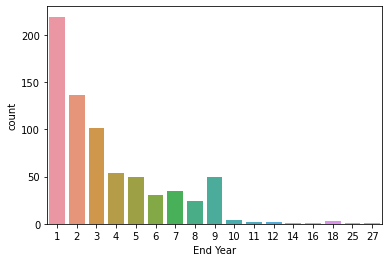

In [86]:
sns.countplot(id_freq_schools['End Year'], label='count')

In [87]:
# Select frequency that a school appears in either the top or bottom percentile of the highly impacted schools
# There should be a default selected. 

select_frequency = 5

# If school code frequency is >= 5 years, then they remain. Unless above variable is updated to a different number.   

for i in id_freq_schools.index:
  if id_freq_schools['End Year'][i] < select_frequency:
    id_freq_schools.drop([i], axis= 0, inplace=True)

freq_school_code = id_freq_schools.index.unique().sort_values()

In [88]:
freq_school_code

Int64Index([  6010,  11022,  11025,  16011,  21027,  21050,  26010,  26020,
             31180,  35011,
            ...
            501390, 501395, 505010, 525014, 537010, 567020, 571002, 571230,
            585125, 585130],
           dtype='int64', name='School Code', length=203)

In [89]:
# This is the detailed schools who are repeatedly in the top/bottom.
# Pulls all of their school data. 

ten_year_impacted = published_ky_df.iloc[0:0,:]

for code in freq_school_code:
  school_ten_year = published_ky_df[published_ky_df['School Code'] == code]
  ten_year_impacted = ten_year_impacted.append(school_ten_year)


In [90]:
ten_year_impacted.sort_values(by=['Money Difference per school'], inplace=True)

In [91]:
ten_year_impacted

,End Year,District Code,District,School Code,School,Level,Proficiency Rate,Classification,Rating,Reported Spending per student,Money Difference per school,Money Difference per student,Estimated Spending per student
572,"2,012.00",275,Jefferson County,275620,Frederick Law Olmsted Academy North,MS,34.00,Needs Improvement,*Low,"10,980.00","-666,200.00",-880.00,"10,097.00"
9048,"2,019.00",275,Jefferson County,275155,Marion C. Moore School,HS,31.00,Needs Improvement,Very Low,"14,030.00","-643,000.00",-290.00,"13,743.00"
4210,"2,015.00",275,Jefferson County,275033,Valley High,HS,59.00,Needs Improvement,*Low,"10,270.00","-634,200.00",-450.00,"9,822.00"
6580,"2,017.00",275,Jefferson County,275155,Marion C. Moore School,HS,45.00,*Needs Improvement,*Low,"12,230.00","-621,500.00",-310.00,"11,921.00"
645,"2,012.00",275,Jefferson County,275033,Valley High,HS,31.00,Needs Improvement,*Low,"10,290.00","-551,700.00",-600.00,"9,685.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5692,"2,016.00",452,Newport Independent,452040,Newport Intermediate School,ES,52.00,Needs Improvement,NaN,NaN,NaN,NaN,NaN
6904,"2,017.00",452,Newport Independent,452040,Newport Intermediate School,ES,45.00,NaN,NaN,NaN,NaN,NaN,NaN
8135,"2,018.00",452,Newport Independent,452040,Newport Intermediate School,ES,51.00,NaN,NaN,NaN,NaN,NaN,NaN
9379,"2,019.00",452,Newport Independent,452040,Newport Intermediate School,ES,44.00,Needs Improvement,Very Low,NaN,NaN,NaN,NaN
